 ## Load Dataset

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib  
import boto3

In [17]:
data_hotel = pd.read_csv("data/Hotel Reservations.csv")

In [18]:
data_hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

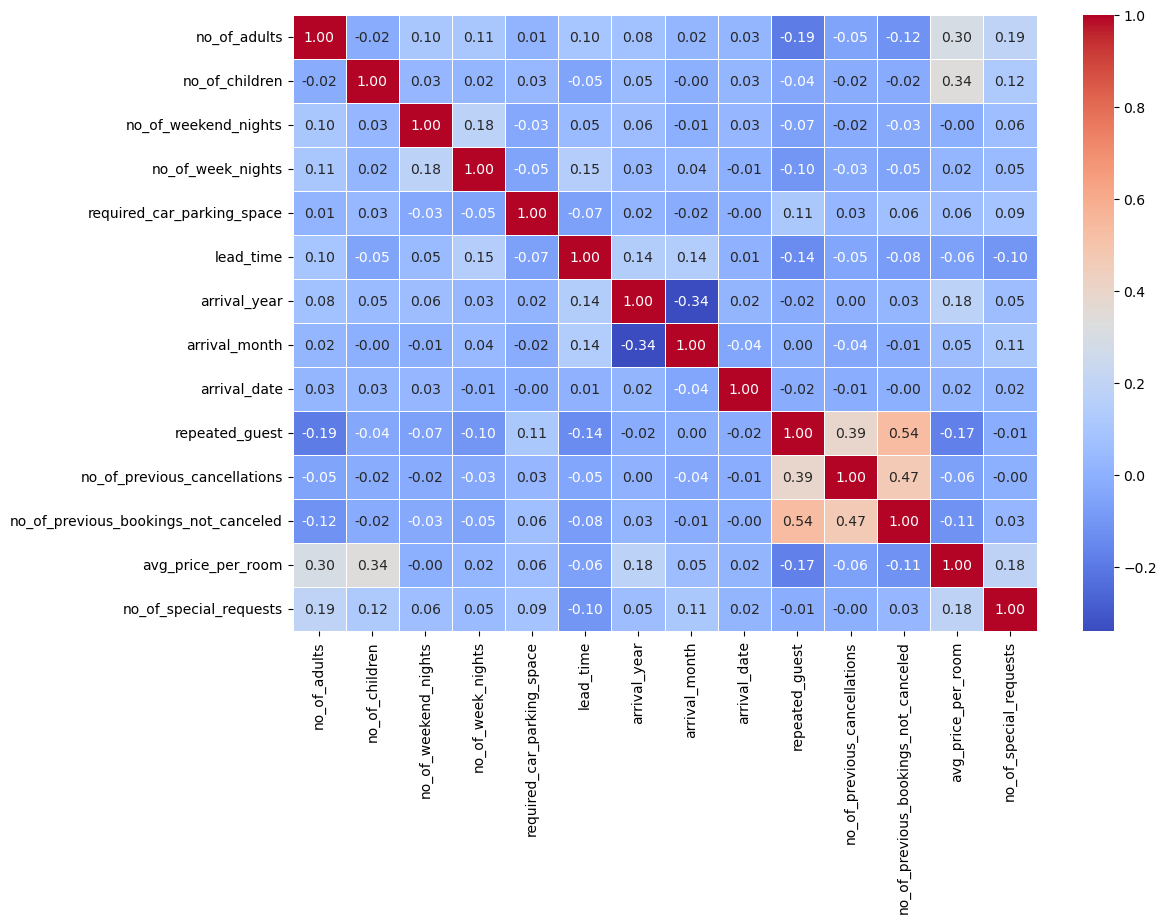

In [19]:
correlation_matrix = data_hotel.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.show()

In [20]:
data_hotel.drop(columns=['Booking_ID', 'type_of_meal_plan', 'booking_status', 'market_segment_type' ], inplace = True)

In [21]:
data_hotel['room_type_reserved'] = data_hotel['room_type_reserved'].str.extract('(\d+)').astype(int)

In [22]:
def label_price(avg_price_per_room):
    if avg_price_per_room <= 85:
        return 1
    elif 85 < avg_price_per_room < 115:
        return 2
    else:
        return 3

data_hotel['label_avg_price_per_room'] = data_hotel['avg_price_per_room'].apply(label_price)

In [23]:
data_hotel.drop(columns=['avg_price_per_room'], inplace=True)

## Training model

In [24]:
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [25]:

X = data_hotel.drop(columns=['label_avg_price_per_room'])
y = data_hotel['label_avg_price_per_room']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [26]:

model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=0)
model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=0)

## Upload model to bucket

In [27]:
joblib.dump(model, 'model.joblib')
s3 = boto3.client('s3')
bucket_name = 'hotelmlbucket'
model_key = 'model.joblib'
s3.upload_file('model.joblib', bucket_name, model_key)


## Predict

In [28]:

y_pred = model.predict(X_test)


 ## Model accuracy score

In [29]:
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Relatory:\n", report)

Accuracy: 0.805237767057202
Relatory:
               precision    recall  f1-score   support

           1       0.80      0.79      0.80      2180
           2       0.77      0.77      0.77      2678
           3       0.84      0.86      0.85      2397

    accuracy                           0.81      7255
   macro avg       0.81      0.81      0.81      7255
weighted avg       0.81      0.81      0.81      7255

